In [2]:
import cv2
import numpy as np
import os

import datetime
from skimage import io
import os
import random
import matplotlib.pyplot as plt
% matplotlib inline
import glob

UsageError: Line magic function `%` not found.


In [5]:
def segment(image, threshold=25):
    global bg
    # find the absolute difference between background and current frame
    diff = cv2.absdiff(bg.astype("uint8"), image)

    # threshold the diff image so that we get the foreground
    thresholded = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)[1]

    # get the contours in the thresholded image
    (cnts, _) = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # return None, if no contours detected
    if len(cnts) == 0:
        return
    else:
        # based on contour area, get the maximum contour which is the hand
        segmented = max(cnts, key=cv2.contourArea)
        return (thresholded, segmented)

### 2D CNN Model

In [6]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Activation, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.optimizers import Adam


# model
model = Sequential()

# first conv layer
# input shape = (img_rows, img_cols, 1)
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(100,120, 1))) 
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# second conv layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flatten and put a fully connected layer
model.add(Flatten())
model.add(Dense(128, activation='relu')) # fully connected
model.add(Dropout(0.5))

# softmax layer
model.add(Dense(6, activation='softmax'))

# model summary
optimiser = Adam() 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 118, 32)       320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 98, 118, 32)       128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 59, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 49, 59, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 47, 57, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 47, 57, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 28, 64)       

### Training the model with the dataset

In [8]:
# Loading the Dataset

DATASET_PATH = '/kaggle/input/hand-gesture-recog-dataset/data'

dataset_path = os.path.join(DATASET_PATH, '*')
import glob
dataset_path = glob.glob(dataset_path)
dataset_path

['/kaggle/input/hand-gesture-recog-dataset/data/five',
 '/kaggle/input/hand-gesture-recog-dataset/data/thumbsdown',
 '/kaggle/input/hand-gesture-recog-dataset/data/ok',
 '/kaggle/input/hand-gesture-recog-dataset/data/blank',
 '/kaggle/input/hand-gesture-recog-dataset/data/fist',
 '/kaggle/input/hand-gesture-recog-dataset/data/thumbsup']

Original Image


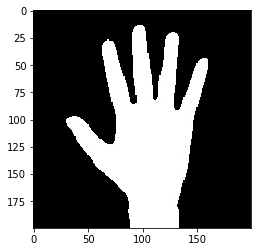

In [9]:
import cv2
image = cv2.imread('/kaggle/input/hand-gesture-recog-dataset/data/five/hand1(1015).jpg')
image_new = cv2.resize(image,(100, 120))
# plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
print("Original Image")
plt.imshow(image)

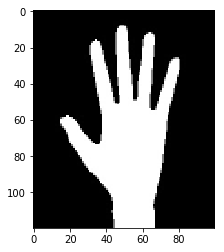

In [10]:
plt.imshow(cv2.cvtColor(image_new, cv2.COLOR_BGR2RGB))

In [11]:
loaded_images = []

list_of_gestures = ['blank', 'ok', 'thumbsup', 'thumbsdown', 'fist', 'five']

for path in range(0, len(dataset_path)):
    dataset_path = "/kaggle/input/hand-gesture-recog-dataset/data/" + str(list_of_gestures[path])
    gesture_path = os.path.join(dataset_path, '*')
    import glob
    gest_path = glob.glob(gesture_path)
    k = 0
    for i in range(0, len(gest_path)):
        if k < 1600:
            image = cv2.imread(gest_path[i])
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray_image = cv2.resize(gray_image,(100, 120))
            loaded_images.append(gray_image)
        k=k+1
print(len(loaded_images))

outputVectors = []
for i in range(1, 1601):
    outputVectors.append([1, 0, 0, 0, 0, 0])

for i in range(1, 1601):
    outputVectors.append([0, 1, 0, 0, 0, 0])

for i in range(1, 1601):
    outputVectors.append([0, 0, 1, 0, 0, 0])
    
for i in range(1, 1601):
    outputVectors.append([0, 0, 0, 1, 0, 0])
    
for i in range(1, 1601):
    outputVectors.append([0, 0, 0, 0, 1, 0])

for i in range(1, 1601):
    outputVectors.append([0, 0, 0, 0, 0, 1])

print(len(outputVectors))

9600
9600


In [12]:
print(loaded_images[0])

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ... 255   5   3]
 [  0   0   0 ... 255 250   1]
 ...
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


In [13]:
print(outputVectors[1])

[1, 0, 0, 0, 0, 0]


In [15]:
X = np.asarray(loaded_images)
y = np.asarray(outputVectors)
print(X.shape)
print(y.shape)

(9600, 120, 100)
(9600, 6)


In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
X_train = X_train.reshape(X_train.shape[0], 100, 120, 1)
X_test = X_test.reshape(X_test.shape[0], 100, 120, 1)
print(X_train.shape)
print(X_test.shape)

(7680, 100, 120, 1)
(1920, 100, 120, 1)


In [19]:
# Training the model with data
model.fit(X_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_test, y_test))

# model.save("hand_gesture_recognition.h5")

Train on 7680 samples, validate on 1920 samples
Epoch 1/10
7680/7680 [==============================] - 4s 582us/step - loss: 0.0228 - categorical_accuracy: 0.9906 - val_loss: 0.0024 - val_categorical_accuracy: 0.9990
Epoch 2/10
7680/7680 [==============================] - 4s 580us/step - loss: 0.0216 - categorical_accuracy: 0.9922 - val_loss: 0.0018 - val_categorical_accuracy: 0.9990
Epoch 3/10
7680/7680 [==============================] - 4s 581us/step - loss: 0.0234 - categorical_accuracy: 0.9905 - val_loss: 0.0014 - val_categorical_accuracy: 0.9995
Epoch 4/10
7680/7680 [==============================] - 4s 582us/step - loss: 0.0308 - categorical_accuracy: 0.9885 - val_loss: 5.2305e-05 - val_categorical_accuracy: 1.0000
Epoch 5/10
7680/7680 [==============================] - 4s 583us/step - loss: 0.0184 - categorical_accuracy: 0.9917 - val_loss: 4.9477e-05 - val_categorical_accuracy: 1.0000
Epoch 6/10
7680/7680 [==============================] - 4s 583us/step - loss: 0.0243 - categor

In [24]:
[loss, acc] = model.evaluate(X_test,y_test,verbose=1)
print("Accuracy: " + str(acc))

1920/1920 [==============================] - 0s 253us/step
Accuracy: 1.0


In [25]:
# Predict on individual samples
sample_index = 0  # Choose the index of the sample you want to predict
input_sample = X_test[sample_index].reshape(1, 100, 120, 1)  # Reshape the input sample for prediction

# Predict the class probabilities for the input sample
predicted_probabilities = model.predict(input_sample)

# Convert the predicted probabilities into a predicted class label
predicted_class_index = np.argmax(predicted_probabilities)
predicted_class = list_of_gestures[predicted_class_index]

print("Predicted class:", predicted_class)


Predicted class: five


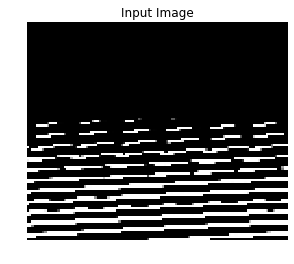

Predicted class: ok


In [28]:
import matplotlib.pyplot as plt

# Predict on individual samples
sample_index = 4  # Choose the index of the sample you want to predict
input_sample = X_test[sample_index].reshape(1, 100, 120, 1)  # Reshape the input sample for prediction

# Predict the class probabilities for the input sample
predicted_probabilities = model.predict(input_sample)

# Convert the predicted probabilities into a predicted class label
predicted_class_index = np.argmax(predicted_probabilities)
predicted_class = list_of_gestures[predicted_class_index]

# Plot the input image
plt.imshow(X_test[sample_index].reshape(100, 120), cmap='gray')
plt.title("Input Image")
plt.axis('off')
plt.show()

print("Predicted class:", predicted_class)


### Get the thresholded image from live feed and use model to predict the hand gesture in image

## Run LIVE FEED

In [ ]:
# # load Model Weights

# def _load_weights():
#     try:
#         model = load_model("hand_gesture_recog_model.h5")
#         print(model.summary())
#         # print(model.get_weights())
#         # print(model.optimizer)
#         return model
#     except Exception as e:
#         return None

    
# def getPredictedClass(model):

#     image = cv2.imread('Temp.png')
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     gray_image = cv2.resize(gray_image, (100, 120))

#     gray_image = gray_image.reshape(1, 100, 120, 1)

#     prediction = model.predict_on_batch(gray_image)

#     predicted_class = np.argmax(prediction)
#     if predicted_class == 0:
#         return "Blank"
#     elif predicted_class == 1:
#         return "OK"
#     elif predicted_class == 2:
#         return "Thumbs Up"
#     elif predicted_class == 3:
#         return "Thumbs Down"
#     elif predicted_class == 4:
#         return "Punch"
#     elif predicted_class == 5:
#         return "High Five"


# if __name__ == "__main__":
#     # initialize accumulated weight
#     accumWeight = 0.5

#     # get the reference to the webcam
#     camera = cv2.VideoCapture(0)

#     fps = int(camera.get(cv2.CAP_PROP_FPS))
#     # region of interest (ROI) coordinates
#     top, right, bottom, left = 10, 350, 225, 590
#     # initialize num of frames
#     num_frames = 0
#     # calibration indicator
#     calibrated = False
#     model = _load_weights()
#     k = 0
#     # keep looping, until interrupted
#     while (True):
#         # get the current frame
#         (grabbed, frame) = camera.read()

#         # resize the frame
#         frame = cv2.resize(frame, (700,700))
#         # flip the frame so that it is not the mirror view
#         frame = cv2.flip(frame, 1)

#         # clone the frame
#         clone = frame.copy()

#         # get the height and width of the frame
#         (height, width) = frame.shape[:2]

#         # get the ROI
#         roi = frame[top:bottom, right:left]

#         # convert the roi to grayscale and blur it
#         gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
#         gray = cv2.GaussianBlur(gray, (7, 7), 0)

#         # to get the background, keep looking till a threshold is reached
#         # so that our weighted average model gets calibrated
#         if num_frames < 30:
#             run_avg(gray, accumWeight)
#             if num_frames == 1:
#                 print("[STATUS] please wait! calibrating...")
#             elif num_frames == 29:
#                 print("[STATUS] calibration successfull...")
#         else:
#             # segment the hand region
#             hand = segment(gray)

#             # check whether hand region is segmented
#             if hand is not None:
#                 # if yes, unpack the thresholded image and
#                 # segmented region
#                 (thresholded, segmented) = hand

#                 # draw the segmented region and display the frame
#                 cv2.drawContours(clone, [segmented + (right, top)], -1, (0, 0, 255))

#                 # count the number of fingers
#                 # fingers = count(thresholded, segmented)
#                 if k % (fps / 6) == 0:
#                     cv2.imwrite('Temp.png', thresholded)
#                     predictedClass = getPredictedClass(model)
#                     cv2.putText(clone, str(predictedClass), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

#                 # show the thresholded image
#                 cv2.imshow("Thesholded", thresholded)
#         k = k + 1
#         # draw the segmented hand
#         cv2.rectangle(clone, (left, top), (right, bottom), (0, 255, 0), 2)

#         # increment the number of frames
#         num_frames += 1

#         # display the frame with segmented hand
#         cv2.imshow("Video Feed", clone)

#         # observe the keypress by the user
#         keypress = cv2.waitKey(1) & 0xFF

#         # if the user pressed "q", then stop looping
#         if keypress == ord("q"):
#             break

#     # free up memory
#     camera.release()
#     cv2.destroyAllWindows()
